In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import re
from functools import reduce
import pandas as pd
path = '../'
if not path in sys.path:
    sys.path.append(path)
from review_scripts.gdrive import google_api, gsheet

In [3]:
sid_interviewadmitted= "1nc9poFeUmo70NzRwo3R_JkgBGU7OD16Ol7MImMOvq3w"
gst = gsheet(sheetid=sid_interviewadmitted,fauth='admin-10ac-service.json') 
dfinterview_response = gst.get_sheet_df('InterviewResponse').T

reading auth from file: ~/.env/gclass_credentials.json ..
****** using service account: ~/.env/gclass_credentials.json
service account is being used without delegation..
token.pickle <class 'str'>


In [4]:
dfinterview_response.head()

,Id,Review_Id,Reviewee,Reviewer,reason_to_join,commitment,pay_it_forward,week0_planing_testing,week0_analysis_exploration,Trainee_question,ontime,communication,hungry,suitablity,prediction,ML_pipline_design,code_underestanding
1,1,5931,janerosenyams@gmail.com,asalawu@10academy.org,Meets Expectation,Yes,Yes,Meets Expectation,Meets Expectation,are we going to trained on the three tracks?,Yes,Meets Expectation,Meets Expectation,Yes,Does Not Meet Expectation,Does Not Meet Expectation,Meets Expectation
2,2,5891,nahomhabtemichael@gmail.com,nardos@10academy.org,Exceeds Expectation,Yes,Yes,Exceeds Expectation,Meets Expectation,They asked what we 10x team like about 10 acad...,Yes,Exceeds Expectation,Exceeds Expectation,Yes,Exceeds Expectation,Does Not Meet Expectation,Meets Expectation
3,3,5896,gedionandme@gmail.com,ehirwa@10academy.org,Exceeds Expectation,Yes,Yes,Exceeds Expectation,Exceeds Expectation,When should he expect feedback,Yes,Exceeds Expectation,Exceeds Expectation,Yes,Exceeds Expectation,Exceeds Expectation,Exceeds Expectation
4,4,5923,gdekebo2020@gmail.com,akiiru@10academy.org,Exceeds Expectation,Yes,Yes,Meets Expectation,Does Not Meet Expectation,No questions.,Yes,Meets Expectation,Meets Expectation,Yes,Meets Expectation,Meets Expectation,Does Not Meet Expectation
5,5,5913,aojutomori@gmail.com,evariste@10academy.org,Meets Expectation,Yes,Yes,Does Not Meet Expectation,Does Not Meet Expectation,Do you have any curriculum that you will share...,Yes,Does Not Meet Expectation,Meets Expectation,No,Does Not Meet Expectation,Does Not Meet Expectation,Does Not Meet Expectation


reading auth from file: ~/.env/gclass_credentials.json ..
****** using service account: ~/.env/gclass_credentials.json
service account is being used without delegation..
token.pickle <class 'str'>


In [56]:
import strapi_graphql

def get_accepted_trainee(batch=6, 
                         status='Accepted',
                         root='cms',
                         ssmkey='dev/strapi/token'):
  
  sg = strapi_graphql.StrapiGraphql(root=root, ssmkey=ssmkey)
  
  bquery = """
            query getTrainees($batch:Int,$status:String){
                  trainees(
                    pagination: { start: 0, limit: 200 }
                    filters: { batch: { Batch: { eq: $batch } }, Status:{eq:$status} }
                  ) {
                    meta {
                      pagination {
                        total
                      }
                    }
                    data {
                      attributes {
                        email
                        all_user {
                          data {
                            id
                            attributes {
                              email
                            }
                          }
                        }
                      }
                    }
                  }
                }
        """
  traineeJson = sg.Select_from_table(query=bquery, variables={"batch": batch, "status":status})   # 

  traineedf = pd.json_normalize(traineeJson['data']['trainees']['data'])
  traineedf= traineedf.rename(columns={'attributes.all_user.data.id':'id',
                                       "attributes.email":"trainee_email", 
                                       "attributes.all_user.data.attributes.email":"email"})
    
  return traineedf
  

  


In [87]:
def merged_interview_df(gsid="1nc9poFeUmo70NzRwo3R_JkgBGU7OD16Ol7MImMOvq3w",
                        sheetname='FinalAdmitInterview', sheet_name_addmited = "InterviewResponse",
                        trkw={}):
  
  dftrainee = get_accepted_trainee(**trkw)
  
  
  gst = gsheet(sheetid=gsid,fauth='admin-10ac-service.json') 
  dfinterview = gst.get_sheet_df(sheetname).T
  
  merged_df = pd.merge(dfinterview, dftrainee, on="email", how= "left")
  df_final = merged_df[~merged_df['id'].isna()]
  
  # Get Interview response from sheet
  dfinterview_response = gst.get_sheet_df(sheet_name_addmited).T
  dfinterview_response.rename(columns={"Reviewee":"email"}, inplace=True)	
  
  # remove duplicates
  dfinterview_response = dfinterview_response.drop_duplicates(subset=['Review_Id', 'Reviewer'], keep='first')
  
  dfinterview = pd.merge( df_final,dfinterview_response, on="email", how= "left")
  
  keepcols = ['Name', 'email','Gender', 'Rank','Nationality', 'Week Score',  
        'Score',  'Reviewer', 'reason_to_join', 'commitment',
       'pay_it_forward', 'week0_planing_testing', 'week0_analysis_exploration',
       'Trainee_question', 'ontime', 'communication', 'hungry', 'suitablity',
       'prediction', 'ML_pipline_design', 'code_underestanding']
  dfinterview = dfinterview[keepcols]
  
  dfnull = dfinterview[dfinterview["pay_it_forward"].isna()]
  print("Not reviewed emails",dfnull['email'].tolist() )
  
  dfall = dfinterview[~dfinterview["Reviewer"].isna()]
  cols = ['reason_to_join', 'commitment', 'pay_it_forward',
       'week0_planing_testing', 'week0_analysis_exploration',
       'Trainee_question', 'ontime', 'communication', 'hungry', 'suitablity',
       'prediction', 'ML_pipline_design', 'code_underestanding']
  for i in cols:
    dfall[i].replace('', "No Answer", inplace=True)
    
     
  return dfall

In [88]:
dfall = merged_interview_df()

reading auth from file: /home/mahlet/.env/cms.json ..
reading auth from file: ~/.env/gclass_credentials.json ..
****** using service account: ~/.env/gclass_credentials.json
service account is being used without delegation..
token.pickle <class 'str'>
Not reviewed emails ['egidekamuzinzi@gmail.com', 'birtukankuma1113@gmail.com']


/tmp/ipykernel_8883/4205990532.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfall[i].replace('', "No Answer", inplace=True)


In [89]:
dfall.columns

Index(['Name', 'email', 'Gender', 'Rank', 'Nationality', 'Week Score', 'Score',
       'Reviewer', 'reason_to_join', 'commitment', 'pay_it_forward',
       'week0_planing_testing', 'week0_analysis_exploration',
       'Trainee_question', 'ontime', 'communication', 'hungry', 'suitablity',
       'prediction', 'ML_pipline_design', 'code_underestanding'],
      dtype='object')

In [90]:
dfall['commitment'].unique()

array(['Yes', 'No', 'No Answer'], dtype=object)

In [78]:
dfall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 135
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Name                        134 non-null    object
 1   email                       134 non-null    object
 2   Gender                      134 non-null    object
 3   Rank                        134 non-null    object
 4   Nationality                 134 non-null    object
 5   Week Score                  134 non-null    object
 6   Score                       134 non-null    object
 7   Reviewer                    134 non-null    object
 8   reason_to_join              134 non-null    object
 9   commitment                  134 non-null    object
 10  pay_it_forward              134 non-null    object
 11  week0_planing_testing       134 non-null    object
 12  week0_analysis_exploration  134 non-null    object
 13  Trainee_question            134 non-null    object

### Maps questions with equivalent values

In [145]:
def map_question_with_values(df):
    m1 = {'Exceeds Expectation': 5,'Meets Expectation': 4, 
                                                'Does Not Meet Expectation':2,'Not Applicable':0,
                                                'No Answer':0
                                                }
    m2 = {'Exceeds Expectation': 1,'Meets Expectation': 1, 
                                                'Does Not Meet Expectation':0,'Not Applicable':0,
                                                'No Answer':0
                                                }
    m3 = {'Exceeds Expectation': 2,'Meets Expectation': 1, 
                                                'Does Not Meet Expectation':-1,'Not Applicable':-1,
                                                'No Answer':-1
                                                }
    m4 = {'Yes':1, 'No':-1,'No Answer':-1}

    qmap = {'reason_to_join':m3, 
            'commitment':m4, 
            'pay_it_forward':m4,
            'week0_planing_testing':m3, 
            'week0_analysis_exploration':m3,
            'ontime':m4, 
            'communication':m3, 
            'hungry':m3, 
            'suitablity':m4,
            'prediction':m3, 
            'ML_pipline_design':m3, 
            'code_underestanding':m3}

    dft = df.copy()
    for col in qmap.keys():
        dft[col] = dft[col].map(qmap.get(col, m3)) #[col].map(qmap.get(col, m3))
    return qmap, dft

In [146]:

qmap, dft= map_question_with_values(dfall)
dft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 135
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Name                        134 non-null    object
 1   email                       134 non-null    object
 2   Gender                      134 non-null    object
 3   Rank                        134 non-null    object
 4   Nationality                 134 non-null    object
 5   Week Score                  134 non-null    object
 6   Score                       134 non-null    object
 7   Reviewer                    134 non-null    object
 8   reason_to_join              134 non-null    int64 
 9   commitment                  134 non-null    int64 
 10  pay_it_forward              134 non-null    int64 
 11  week0_planing_testing       134 non-null    int64 
 12  week0_analysis_exploration  134 non-null    int64 
 13  Trainee_question            134 non-null    object

In [144]:
dft

,Name,email,Gender,Rank,Nationality,Week Score,Score,Reviewer,reason_to_join,commitment,...,week0_planing_testing,week0_analysis_exploration,Trainee_question,ontime,communication,hungry,suitablity,prediction,ML_pipline_design,code_underestanding
0,Natnael Melese,natrix277@gmail.com,Male,q4,Ethiopia,100,67,atamrat@10academy.org,1,1,...,2,2,What's expected from us? (the trainees) and ho...,1,2,2,1,2,2,2
1,Natnael Melese,natrix277@gmail.com,Male,q4,Ethiopia,100,67,evariste@10academy.org,1,1,...,1,1,Is the job-search phase part of the 12 weeks o...,1,1,1,1,1,0,1
2,Natnael Melese,natrix277@gmail.com,Male,q4,Ethiopia,100,67,mmusa@10academy.org,1,1,...,1,1,How do i compete with someone with 3 years exp...,1,1,1,1,1,1,1
3,Natnael Melese,natrix277@gmail.com,Male,q4,Ethiopia,100,67,yididya@10academy.org,2,1,...,2,2,What's expected from us on the first day of tr...,1,2,2,1,1,1,1
4,Yohans Samuel,yohanssamuel2014@gmail.com,Male,q4,Ethiopia,100,85,yabebal@10academy.org,2,1,...,2,2,Asked relevant question,1,2,2,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,Sika Fidèle,sikawando@gmail.com,Male,q3,Benin,32,48,mmusa@10academy.org,0,-1,...,-1,-1,1. Date for next batch,1,1,-1,-1,-1,-1,-1
132,Dawit Asmero,dawitasmero@gmail.com,Male,q3,Ethiopia,31,65,mmusa@10academy.org,1,1,...,1,1,No questions,1,1,1,1,0,0,1
133,Dawit Asmero,dawitasmero@gmail.com,Male,q3,Ethiopia,31,65,arun@10academy.org,1,1,...,-1,-1,No time.,-1,0,0,-1,0,-1,-1
134,Gloria Niyonkuru,gsinseswa721@daviscollege.com,Female,q3,Rwanda,30,49,yididya@10academy.org,1,1,...,1,0,No.,1,1,1,1,1,0,1


In [147]:
colcol = 'Reviewer'
valcols = 'suitablity'
rmcols = list(qmap.keys())
rmcols.remove(valcols)

dfaccept = dft.drop(columns=rmcols)


idcols = list(dfaccept.columns)
idcols.remove(colcol)
idcols.remove(valcols)

dfpivot = dfaccept.pivot_table(columns=colcol,index=idcols,values=valcols)
dfpivot = dfpivot.reset_index()

email_columns = [x for x in dfpivot.columns if '@' in x]
func = lambda x: 'sum' if x in email_columns else 'first'
aggdict = {x: func(x) for x in dfpivot.columns}
dfpivot = dfpivot.groupby('email').agg(aggdict)

dfpivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, amanuelzewdu21@gmail.com to zelalemshiferaw71921@gmail.com
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    55 non-null     object 
 1   email                   55 non-null     object 
 2   Gender                  55 non-null     object 
 3   Rank                    55 non-null     object 
 4   Nationality             55 non-null     object 
 5   Week Score              55 non-null     object 
 6   Score                   55 non-null     object 
 7   Trainee_question        55 non-null     object 
 8   akiiru@10academy.org    55 non-null     float64
 9   arun@10academy.org      55 non-null     float64
 10  asa@10academy.org       55 non-null     float64
 11  asalawu@10academy.org   55 non-null     float64
 12  atamrat@10academy.org   55 non-null     float64
 13  ehirwa@10academy.org    55 non-null     float64
 14

In [148]:
dfpivot[email_columns]

Reviewer,akiiru@10academy.org,arun@10academy.org,asa@10academy.org,asalawu@10academy.org,atamrat@10academy.org,ehirwa@10academy.org,evariste@10academy.org,mmusa@10academy.org,nardos@10academy.org,yabebal@10academy.org,yididya@10academy.org
email,,,,,,,,,,,
amanuelzewdu21@gmail.com,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
amdeamd7@gmail.com,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
andenet.dev@gmail.com,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
antenehtilaye19@gmail.com,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
aojutomori@gmail.com,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,1.0,0.0
aririjoseph@gmail.com,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0
axutec14@gmail.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
bekiman21@gmail.com,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
birhanugebisa@gmail.com,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [150]:
import numpy as np
dfpivot[email_columns] = dfpivot[email_columns].replace({0:np.nan})
dfpivot[email_columns]

Reviewer,akiiru@10academy.org,arun@10academy.org,asa@10academy.org,asalawu@10academy.org,atamrat@10academy.org,ehirwa@10academy.org,evariste@10academy.org,mmusa@10academy.org,nardos@10academy.org,yabebal@10academy.org,yididya@10academy.org
email,,,,,,,,,,,
amanuelzewdu21@gmail.com,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
amdeamd7@gmail.com,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
andenet.dev@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
antenehtilaye19@gmail.com,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
aojutomori@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,1.0,1.0,NaN
aririjoseph@gmail.com,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,-1.0,NaN
axutec14@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
bekiman21@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
birhanugebisa@gmail.com,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:ylabel='Frequency'>

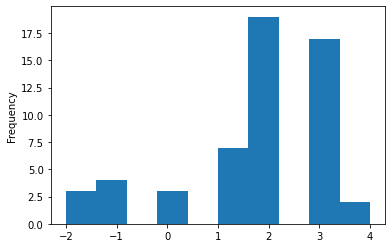

In [151]:
email_columns = [x for x in dfpivot.columns if '@' in x]
dfpivot['nyesno'] = dfpivot[email_columns].notnull().sum(axis=1)
dfpivot['sumyes'] = dfpivot[email_columns].fillna(0).sum(axis=1) #dropna(axis=1,how='all').info()
dfpivot['meanyes'] = dfpivot['sumyes']/dfpivot['nyesno']

dfpivot['sumyes'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

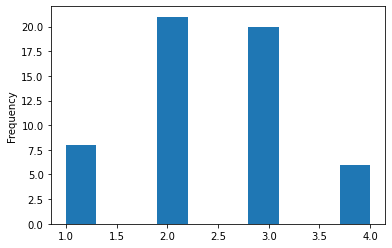

In [152]:
dfpivot['nyesno'].plot.hist()


<AxesSubplot:ylabel='Frequency'>

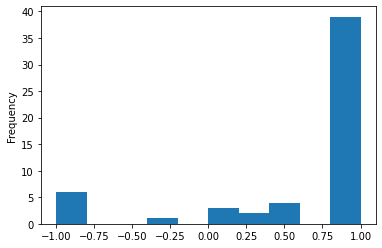

In [153]:
dfpivot['meanyes'].plot.hist()

In [159]:
x = dfpivot['meanyes'][0]

In [167]:
dfyes = dfpivot[dfpivot['meanyes']==1.000000]

In [170]:

gst = gsheet(sheetid=sid_interviewadmitted,fauth='admin-10ac-service.json') 
df = gst.df_to_sheet(dfyes.fillna(0),"AllAgreed")


reading auth from file: ~/.env/gclass_credentials.json ..
****** using service account: ~/.env/gclass_credentials.json
service account is being used without delegation..
token.pickle <class 'str'>


In [171]:

dfmaybe = dfpivot[dfpivot['meanyes'].between(0, 0.75)]
df = gst.df_to_sheet(dfmaybe.fillna(0),"partlyAgreed")


In [ ]:
dfno = dfpivot[dfpivot['meanyes']<0]
df = gst.df_to_sheet(dfno .fillna(0),"notAgreed")


### Show Interesting Stats 

In [20]:
counter = lambda x : x.value_counts().to_dict()
dfstat2 = (dfall[['Name', 'email', 'Gender', 'Rank', 'Nationality', 'Week Score', 'Score',
       'Reviewer', 'reason_to_join', 'commitment', 'pay_it_forward',
       'week0_planing_testing', 'week0_analysis_exploration',
       'Trainee_question', 'ontime', 'communication', 'hungry', 'suitablity',
       'prediction'
       ]]
            .groupby(['Reviewer'])
            .agg({'Gender':counter,'Nationality':counter,'prediction':counter,'pay_it_forward':counter, 'suitablity':counter})
            .reset_index()
           )

dfstat2

,Reviewer,Gender,Nationality,prediction,pay_it_forward,suitablity
0,akiiru@10academy.org,"{'Male': 14, 'Female': 3}","{'Ethiopia': 12, 'Benin': 1, 'Kenya': 1, 'Nige...","{'Meets Expectation': 12, 'Exceeds Expectation...",{'Yes': 17},"{'Yes': 15, 'No': 2}"
1,arun@10academy.org,"{'Male': 3, 'Female': 1}","{'Benin': 1, 'Rwanda': 1, 'Sudan': 1, 'Ethiopi...","{'Meets Expectation': 2, 'No Answer': 1, 'Does...","{'Yes': 3, 'No Answer': 1}","{'Yes': 2, 'No Answer': 1, 'No': 1}"
2,asa@10academy.org,"{'Male': 2, 'Female': 1}",{'Ethiopia': 3},"{'Meets Expectation': 2, 'No Answer': 1}","{'Yes': 2, 'No Answer': 1}","{'Yes': 2, 'No Answer': 1}"
3,asalawu@10academy.org,"{'Male': 13, 'Female': 4}","{'Ethiopia': 12, 'Kenya': 2, 'Nigeria': 1, 'Su...","{'Meets Expectation': 15, 'Exceeds Expectation...",{'Yes': 17},"{'Yes': 16, 'No': 1}"
4,atamrat@10academy.org,"{'Male': 6, 'Female': 4}","{'Ethiopia': 9, 'Rwanda': 1}","{'Exceeds Expectation': 7, 'Does Not Meet Expe...",{'Yes': 10},"{'Yes': 9, 'No': 1}"
5,ehirwa@10academy.org,"{'Male': 10, 'Female': 6}","{'Ethiopia': 11, 'Kenya': 2, 'Benin': 1, 'Nige...","{'Meets Expectation': 10, 'Exceeds Expectation...","{'Yes': 12, 'No': 3, 'No Answer': 1}","{'Yes': 13, 'No': 2, 'No Answer': 1}"
6,evariste@10academy.org,"{'Male': 8, 'Female': 6}","{'Ethiopia': 10, 'Nigeria': 2, 'Kenya': 1, 'Su...","{'Meets Expectation': 9, 'Does Not Meet Expect...","{'Yes': 12, 'No': 2}","{'Yes': 11, 'No': 3}"
7,mmusa@10academy.org,"{'Male': 12, 'Female': 6}","{'Ethiopia': 14, 'Rwanda': 2, 'Tanzania': 1, '...","{'Meets Expectation': 7, 'Does Not Meet Expect...","{'Yes': 16, 'No': 2}","{'Yes': 14, 'No': 4}"
8,nardos@10academy.org,"{'Male': 13, 'Female': 5}","{'Ethiopia': 13, 'Sudan': 2, 'Nigeria': 2, 'Ke...","{'Exceeds Expectation': 6, 'Does Not Meet Expe...","{'Yes': 17, 'No': 1}","{'Yes': 16, 'No': 2}"
9,yabebal@10academy.org,"{'Male': 4, 'Female': 2}","{'Ethiopia': 4, 'Nigeria': 2}","{'Exceeds Expectation': 3, 'Meets Expectation'...","{'Yes': 5, 'No': 1}","{'Yes': 5, 'No': 1}"


In [24]:
dfstat22 = dfstat2.astype(str)
dfstat22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Reviewer        11 non-null     object
 1   Gender          11 non-null     object
 2   Nationality     11 non-null     object
 3   prediction      11 non-null     object
 4   pay_it_forward  11 non-null     object
 5   suitablity      11 non-null     object
dtypes: object(6)
memory usage: 656.0+ bytes


In [26]:
gst = gsheet(sheetid=sid_interviewadmitted,fauth='admin-10ac-service.json') 
r = gst.df_to_sheet(dfstat22.reset_index(),'ReviewerStat')

reading auth from file: ~/.env/gclass_credentials.json ..
****** using service account: ~/.env/gclass_credentials.json
service account is being used without delegation..
token.pickle <class 'str'>


In [82]:
data = pd.crosstab(dfall['email'], dfall['Reviewer'], values=dfall.prediction, aggfunc='sum').fillna(0)
data.head()

Reviewer,akiiru@10academy.org,arun@10academy.org,asa@10academy.org,asalawu@10academy.org,atamrat@10academy.org,ehirwa@10academy.org,evariste@10academy.org,mmusa@10academy.org,nardos@10academy.org,yabebal@10academy.org,yididya@10academy.org
email,,,,,,,,,,,
amanuelzewdu21@gmail.com,Exceeds Expectation,0,0,Meets Expectation,0,Meets Expectation,0,0,0,0,0
amdeamd7@gmail.com,Does Not Meet Expectation,0,0,Meets Expectation,0,0,0,0,0,0,0
andenet.dev@gmail.com,0,0,0,0,0,0,Meets Expectation,0,Exceeds Expectation,0,0
antenehtilaye19@gmail.com,Meets Expectation,0,0,Meets Expectation,0,Meets Expectation,0,0,0,0,0
aojutomori@gmail.com,0,0,0,0,0,0,Does Not Meet Expectation,0,Does Not Meet Expectation,Does Not Meet Expectation,0


In [83]:
prediction = pd.merge(dfinterview, data, on='email',how='inner')
prediction.head()

,Name,email,Gender,Rank,Nationality,Week Score,Score,Reviewer,reason_to_join,commitment,...,arun@10academy.org,asa@10academy.org,asalawu@10academy.org,atamrat@10academy.org,ehirwa@10academy.org,evariste@10academy.org,mmusa@10academy.org,nardos@10academy.org,yabebal@10academy.org,yididya@10academy.org
0,Natnael Melese,natrix277@gmail.com,Male,q4,Ethiopia,100,67,atamrat@10academy.org,Meets Expectation,Yes,...,0,0,0,Exceeds Expectation,0,Meets Expectation,Meets Expectation,0,0,Meets Expectation
1,Natnael Melese,natrix277@gmail.com,Male,q4,Ethiopia,100,67,evariste@10academy.org,Meets Expectation,Yes,...,0,0,0,Exceeds Expectation,0,Meets Expectation,Meets Expectation,0,0,Meets Expectation
2,Natnael Melese,natrix277@gmail.com,Male,q4,Ethiopia,100,67,mmusa@10academy.org,Meets Expectation,Yes,...,0,0,0,Exceeds Expectation,0,Meets Expectation,Meets Expectation,0,0,Meets Expectation
3,Natnael Melese,natrix277@gmail.com,Male,q4,Ethiopia,100,67,yididya@10academy.org,Exceeds Expectation,Yes,...,0,0,0,Exceeds Expectation,0,Meets Expectation,Meets Expectation,0,0,Meets Expectation
4,Yohans Samuel,yohanssamuel2014@gmail.com,Male,q4,Ethiopia,100,85,yabebal@10academy.org,Exceeds Expectation,Yes,...,0,0,0,0,0,0,Exceeds Expectation,0,Exceeds Expectation,Exceeds Expectation


In [84]:
dfall['count'] = 1
fd = lambda x : x.value_counts().to_dict()
dfstat3 = (dfall[['Nationality', 'Gender', 'Name', 'email', 
       'Reviewer', 'commitment', 'pay_it_forward','week0_planing_testing', 
       'ontime',  'hungry', 'suitablity','count',
       'prediction']]
            .groupby(['Reviewer'])
            .agg({'count':'sum','prediction':fd})
            .reset_index()
           )
df = dfstat3['prediction'].apply(pd.Series) 
dfstat4 = pd.concat([dfstat3, df],axis=1)
if 'prediction' in dfstat3.columns:
    dfstat3 = dfstat3.drop(columns='prediction')

/tmp/ipykernel_5291/1169152259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfall['count'] = 1


In [85]:
dfstat3 

,Reviewer,count
0,akiiru@10academy.org,17
1,arun@10academy.org,2
2,asa@10academy.org,3
3,asalawu@10academy.org,17
4,atamrat@10academy.org,9
5,ehirwa@10academy.org,14
6,evariste@10academy.org,13
7,mmusa@10academy.org,16
8,nardos@10academy.org,17
9,yabebal@10academy.org,6


In [31]:
dfall['count'] = 1
fd = lambda x : x.value_counts().to_dict()
dfstat2 = (dfall[['Nationality', 'Gender', 'Name', 'email', 
       'Reviewer', 'commitment', 'pay_it_forward','week0_planing_testing', 
       'ontime',  'hungry', 'suitablity','count',
       'prediction']]
            .groupby(['Reviewer','Gender'])
            .agg({'count':'sum','suitablity':fd})
            .reset_index()
           )


df = dfstat2['suitablity'].apply(pd.Series) 
dfstat2 = pd.concat([dfstat2, df],axis=1)
if 'suitablity' in dfstat2.columns:
    dfstat2 = dfstat2.drop(columns='suitablity')
dfstat2 = dfstat2.fillna(0)


/tmp/ipykernel_8883/1070815930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfall['count'] = 1


In [32]:
dfstat2

,Reviewer,Gender,count,Yes,No,No Answer
0,akiiru@10academy.org,Female,3,3.0,0.0,0.0
1,akiiru@10academy.org,Male,14,12.0,2.0,0.0
2,arun@10academy.org,Female,1,0.0,0.0,1.0
3,arun@10academy.org,Male,3,2.0,1.0,0.0
4,asa@10academy.org,Female,1,1.0,0.0,0.0
5,asa@10academy.org,Male,2,1.0,0.0,1.0
6,asalawu@10academy.org,Female,4,4.0,0.0,0.0
7,asalawu@10academy.org,Male,13,12.0,1.0,0.0
8,atamrat@10academy.org,Female,4,4.0,0.0,0.0
9,atamrat@10academy.org,Male,6,5.0,1.0,0.0


In [88]:
dfall.groupby('Reviewer').prediction.value_counts().unstack().fillna(0)

prediction,Does Not Meet Expectation,Exceeds Expectation,Meets Expectation,No Answer,Not Applicable
Reviewer,,,,,
akiiru@10academy.org,2.0,3.0,12.0,0.0,0.0
arun@10academy.org,0.0,0.0,1.0,1.0,0.0
asa@10academy.org,0.0,0.0,2.0,1.0,0.0
asalawu@10academy.org,1.0,1.0,15.0,0.0,0.0
atamrat@10academy.org,2.0,6.0,1.0,0.0,0.0
ehirwa@10academy.org,0.0,3.0,10.0,1.0,0.0
evariste@10academy.org,3.0,0.0,8.0,0.0,2.0
mmusa@10academy.org,5.0,2.0,7.0,0.0,2.0
nardos@10academy.org,5.0,6.0,4.0,0.0,2.0


In [52]:
dfall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 135
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Name                        134 non-null    object 
 1   email                       134 non-null    object 
 2   Gender                      134 non-null    object 
 3   Rank                        134 non-null    object 
 4   Nationality                 134 non-null    object 
 5   Week Score                  134 non-null    object 
 6   Score                       134 non-null    object 
 7   Reviewer                    134 non-null    object 
 8   reason_to_join              131 non-null    float64
 9   commitment                  0 non-null      float64
 10  pay_it_forward              0 non-null      float64
 11  week0_planing_testing       131 non-null    float64
 12  week0_analysis_exploration  131 non-null    float64
 13  Trainee_question            134 non

In [45]:
m1 = {'Exceeds Expectation': 5,'Meets Expectation': 4, 
                                            'Does Not Meet Expectation':2,'Not Applicable':0,
                                            'No Answer':0
                                            }
m2 = {'Exceeds Expectation': 1,'Meets Expectation': 1, 
                                            'Does Not Meet Expectation':0,'Not Applicable':0,
                                            'No Answer':0
                                            }
m3 = {'Exceeds Expectation': 2,'Meets Expectation': 1, 
                                            'Does Not Meet Expectation':0,'Not Applicable':0,
                                            'No Answer':0
                                            }
m4 = {'yes':1, 'no':0}

qmap = {'reason_to_join':m3, 
        'commitment':m4, 
        'pay_it_forward':m4,
        'week0_planing_testing':m3, 
        'week0_analysis_exploration':m3,
        'ontime':m4, 
        'communication':m3, 
        'hungry':m3, 
        'suitablity':m4,
        'prediction':m3, 
        'ML_pipline_design':m3, 
        'code_underestanding':m3}

dft = dfall.copy()
for col in qmap.keys():
     dft[col] = dft[col].map(qmap.get(col, m3)) #[col].map(qmap.get(col, m3))
dft.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 135
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Name                        134 non-null    object 
 1   email                       134 non-null    object 
 2   Gender                      134 non-null    object 
 3   Rank                        134 non-null    object 
 4   Nationality                 134 non-null    object 
 5   Week Score                  134 non-null    object 
 6   Score                       134 non-null    object 
 7   Reviewer                    134 non-null    object 
 8   reason_to_join              0 non-null      float64
 9   commitment                  0 non-null      float64
 10  pay_it_forward              0 non-null      float64
 11  week0_planing_testing       0 non-null      float64
 12  week0_analysis_exploration  0 non-null      float64
 13  Trainee_question            134 non

In [51]:
colcol = 'Reviewer'
valcols = 'suitablity'
rmcols = list(qmap.keys())
rmcols.remove(valcols)

dfaccept = dft.drop(columns=rmcols)


idcols = list(dfaccept.columns)
idcols.remove(colcol)
idcols.remove('count')
idcols.remove(valcols)

dfpivot = dfaccept.pivot(columns=colcol,index=idcols,values=valcols)
dfpivot = dfpivot.reset_index()
dfpivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    127 non-null    object 
 1   email                   127 non-null    object 
 2   Gender                  127 non-null    object 
 3   Rank                    127 non-null    object 
 4   Nationality             127 non-null    object 
 5   Week Score              127 non-null    object 
 6   Score                   127 non-null    object 
 7   Trainee_question        127 non-null    object 
 8   akiiru@10academy.org    0 non-null      float64
 9   arun@10academy.org      0 non-null      float64
 10  asa@10academy.org       0 non-null      float64
 11  asalawu@10academy.org   0 non-null      float64
 12  atamrat@10academy.org   0 non-null      float64
 13  ehirwa@10academy.org    0 non-null      float64
 14  evariste@10academy.org  0 non-null      fl

In [35]:
data ['total'] = data.select_dtypes(float).sum(1)

In [36]:
data.shape

(55, 12)

In [38]:
prediction = pd.merge(df_final, data, on='email',how='inner')
prediction.head()

,index,Name,Rank,Week Score,Previous Week Score,Gender,Nationality,Score,email,trainee_email,...,asa@10academy.org,asalawu@10academy.org,atamrat@10academy.org,ehirwa@10academy.org,evariste@10academy.org,mmusa@10academy.org,nardos@10academy.org,yabebal@10academy.org,yididya@10academy.org,total
0,0,Natnael Melese,q4,100,0,Male,Ethiopia,67,natrix277@gmail.com,natrix277@gmail.com,...,0.0,0.0,5.0,0.0,4.0,4.0,0.0,0.0,4.0,17.0
1,1,Yohans Samuel,q4,100,0,Male,Ethiopia,85,yohanssamuel2014@gmail.com,yohanssamuel2014@gmail.com,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,5.0,15.0
2,2,Degaga Wolde,q4,95,0,Male,Ethiopia,65,degagawolde@gmail.com,degagawolde@gmail.com,...,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,15.0
3,3,Zelalem Shiferaw,q4,95,0,Male,Ethiopia,71,zelalemshiferaw71921@gmail.com,zelalemshiferaw71921@gmail.com,...,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,4.0,13.0
4,4,Birhanu Gebisa,q4,92,0,Male,Ethiopia,67,birhanugebisa@gmail.com,birhanugebisa@gmail.com,...,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,12.0


In [39]:
prediction.shape

(55, 23)

In [ ]:
gst = gdr.gsheet(sheetid=sid_interviewadmitted,fauth='admin-10ac-service.json') 
r = gst.df_to_sheet(prediction.reset_index(),'PredictionStat')

In [44]:
dfstatx = (dfall[['Nationality', 'Gender', 'Name', 'email', 'Id', 'Review_Id',
       'Reviewer', 'commitment', 'pay_it_forward','week0_planing_testing', 
       'ontime',  'hungry', 'suitablity','count',
       'prediction']]
            .groupby(['Reviewer','Gender'])
            .agg({'count':'sum','suitablity':fd})
            .reset_index()
           )


df = dfstatx['suitablity'].apply(pd.Series) 
dfstat2 = pd.concat([dfstatx, df],axis=1)
if 'suitablity' in dfstatx.columns:
    dfstatx = dfstatx.drop(columns='suitablity')
dfstatx = dfstatx.fillna(0)
dfstatx.head()

,Reviewer,Gender,count
0,akiiru@10academy.org,Male,2
1,asalawu@10academy.org,Male,1
2,mmusa@10academy.org,Male,1
3,nardos@10academy.org,Male,2
4,yididya@10academy.org,Male,1


In [45]:
dfall['count']=1
fd = lambda x : x.value_counts().to_dict()
dfontime = (dfall[['Nationality', 'Gender', 'Name', 'email', 'Id', 'Review_Id',
       'Reviewer', 'commitment', 'pay_it_forward','week0_planing_testing', 
       'ontime',  'hungry', 'suitablity','count',
       'prediction']]
            .groupby(['email','Gender'])
            .agg({'count':'sum','ontime':fd})
            .reset_index()
           )


In [46]:
dfontime

,email,Gender,count,ontime
0,amanuelzewdu21@gmail.com,Male,1,{}
1,amdeamd7@gmail.com,Male,1,{'Yes': 1}
2,andenet.dev@gmail.com,Male,1,{}
3,antenehtilaye19@gmail.com,Male,1,{}
4,aojutomori@gmail.com,Female,1,{}
5,aririjoseph@gmail.com,Male,1,{}
6,axutec14@gmail.com,Male,1,{}
7,bekiman21@gmail.com,Male,1,{}
8,birhanugebisa@gmail.com,Male,1,{}
9,birtukankuma1113@gmail.com,Female,1,{}
